In [4]:
%config IPCompleter.greedy=True

In [55]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import numpy as np
import json
import seaborn as sns
import folium
from folium.plugins import HeatMap
import os
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.offsetbox import AnchoredText
import branca.colormap as cm

Lets have a look at the model grid data contained in the Area Peril dictionary file. 
Note that the dictionary is only meta-data, and not required for model execution.

In [9]:
area_peril_dictionary = pd.read_csv("./keys_data/MEEQ/area_peril_dict.csv")
area_peril_dictionary.head()

,AREA_PERIL_ID,LONGITUDE,LATITUDE
0,1005275201,35.4500,33.7167
1,1005274201,35.5167,33.7167
2,1005258001,35.4542,33.7292
3,1005257901,35.4542,33.7375
4,1005254601,35.5208,33.7375


In [33]:
m = folium.Map(location=[	33.85, 35.50], zoom_start=12, tiles='cartodbpositron')
for i, row in area_peril_dictionary.iterrows():
    folium.CircleMarker(
        location=[row.LATITUDE, row.LONGITUDE], radius=1).add_to(m)
m.fit_bounds(m.get_bounds())
m

Lets have a look at the data contained in the Intensity Bin dictionary file. 
Note that the dictionary is only meta-data, and not required for model execution.

In [103]:
intensity_bin_dictionary = pd.read_csv("./model_data/MEEQ/intensity_bin_dict.csv")
intensity_bin_dictionary.head()

,BIN_INDEX,BIN_FROM,BIN_TO,INTERPOLATION,INTERVAL_TYPE
0,1,0.0,0.1,0.05,1202
1,2,0.1,0.2,0.15,1202
2,3,0.2,0.3,0.25,1202
3,4,0.3,0.4,0.35,1202
4,5,0.4,0.5,0.45,1202


Lets have a look at the data contained in the footprint file. 

In [77]:
! ls model_data
footprints = pd.read_csv("./model_data/MEEQ/footprint_subset.csv")
footprints.head()
max(footprints.intensity_bin_id)

EuWs  MEEQ


30

Lets visualize the first 5 event footprints.

In [88]:
footprints.head()

,event_id,areaperil_id,intensity_bin_id,probability
0,3342,1005237101,1,0.968867
1,3342,1005237101,2,0.008444
2,3342,1005237101,3,0.006488
3,3342,1005237101,4,0.004874
4,3342,1005237101,5,0.003579


In [87]:
area_peril_dictionary.head()

,AREA_PERIL_ID,LONGITUDE,LATITUDE
0,1005275201,35.4500,33.7167
1,1005274201,35.5167,33.7167
2,1005258001,35.4542,33.7292
3,1005257901,35.4542,33.7375
4,1005254601,35.5208,33.7375


In [95]:
footprints_with_hazard = footprints.merge(
    area_peril_dictionary, how='inner', 
    left_on='areaperil_id', right_on='AREA_PERIL_ID')

footprints_with_hazard.head()

linear = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=min(footprints.intensity_bin_id), 
    vmax=max(footprints.intensity_bin_id)
)
m = folium.Map(location=[33.85, 35.50], zoom_start=12, tiles='cartodbpositron')
event_id = 3342

for i, row in footprints_with_hazard[footprints_with_hazard.event_id == event_id].iterrows():
    c = linear(row.intensity_bin_id)
    folium.CircleMarker(
        location=[row.LATITUDE, row.LONGITUDE], fill_color=c, radius=5,
        weight=0, fill=True, fill_opacity=1.0).add_to(m)
m.fit_bounds(m.get_bounds())
linear.caption = 'Hazard'
m.add_child(linear)
m

Lets have a look at the data contained in the Damage Bin dictionary file. 
Note that the dictionary is required for model execution.

In [96]:
damage_bin_dictionary = pd.read_csv("./model_data/MEEQ/damage_bin_dict.csv")
damage_bin_dictionary.head()

,bin_index,bin_from,bin_to,interpolation,interval_type
0,1,0.000,0.000,0.0000,1201
1,2,0.000,0.001,0.0005,1201
2,3,0.001,0.020,0.0105,1201
3,4,0.020,0.040,0.0300,1201
4,5,0.040,0.060,0.0500,1201


Lets have a look at the data contained in the Vulnerability file. 

In [99]:
vulnerabilities = pd.read_csv("./model_data/MEEQ/vulnerability_subset.csv")
vulnerabilities.head()

,vulnerability_id,intensity_bin_id,damage_bin_id,probability
0,712,1,1,1.000000
1,712,2,1,1.000000
2,712,3,2,0.516807
3,712,3,3,0.464853
4,712,3,4,0.013151


The model has seperate vulnerability curves for Residential, Commerical and Industrial occupancies. 
Lets visualise these curves.

AttributeError: 'DataFrame' object has no attribute 'interpolation'

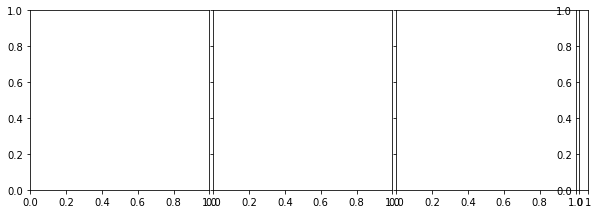

In [107]:
vulnerabilities_with_hazard_and_damage = vulnerabilities.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_id', right_on='BIN_INDEX').merge(
    damage_bin_dictionary, how='inner',
    suffixes=["_i", "_d"], left_on='damage_bin_id', right_on='bin_index')

fig = plt.figure(figsize=(10,20))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

labels = ["Residential", "Commercial", "Industrial"]
for idx, ax in enumerate(grid):
    a = np.zeros((29, 12))
    for index, row in vulnerabilities_with_hazard_and_damage[
        vulnerabilities_with_hazard_and_damage.vulnerability_id == idx + 1].iterrows():
        a[int(row.bin_index_i-1), 11-int(row.bin_index_d-1)] = row.prob
    
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'),
                   extent=(
                       min(intensity_bin_dictionary.INTERPOLATIOJN), max(intensity_bin_dictionary.interpolation), 
                       min(damage_bin_dictionary.interpolation) * 100, max(damage_bin_dictionary.interpolation) * 100))

    at = AnchoredText(labels[idx],
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    ax.set_xlabel("Intensity - Peak gust (mph)")
    ax.set_ylabel("Damage")

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Probability of damage")

plt.show()

To run the model we need some test exxposure data. Lets have a look at an example Location and Account file. 

In [ ]:
test_locations = pd.read_csv('./tests/data/SourceLocPiWind.csv')
test_locations.head()

In [ ]:
test_accounts = pd.read_csv('./tests/data/SourceAccPiWind.csv')
test_accounts.head()

To run the model, we also need to define some analysis settings. Lets have a look at an example settings file.

In [ ]:
with open('./analysis_settings.json', 'r') as myfile:
    analysis_settings=json.loads(myfile.read().replace('\n', ''))
print(json.dumps(analysis_settings, indent=True))

We can now run the model using the Oasis MDK.

In [ ]:
with open('./analysis_settings.json', 'r') as myfile:
    analysis_settings=json.loads(myfile.read().replace('\n', ''))
print(json.dumps(analysis_settings, indent=True))

In [ ]:
! rm -rf /tmp/analysis_test
! oasislmf model run -C oasislmf.json -r /tmp/analysis_test

Lets visualize the output of our analysis.

In [100]:
analysis_directory = "/tmp/analysis_test"
gul_aep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_aep.csv"))
gul_oep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_oep.csv"))
eps = pd.merge(gul_oep, gul_aep, on=["summary_id", "return_period"], suffixes=["_oep", "_aep"])
eps = eps.sort_values(by="return_period", ascending=True)
fig, ax = plt.subplots()
eps.plot(ax=ax, kind='bar', x='return_period', y=["loss_oep", "loss_aep"])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xticklabels(['{:,}'.format(int(x)) for x in eps.return_period])
plt.legend(('OEP', 'AEP'))
ax.set_xlabel("Return period (years)")
ax.set_ylabel("Loss")

FileNotFoundError: File b'/tmp/analysis_test/output/gul_S1_leccalc_full_uncertainty_aep.csv' does not exist